<a href="https://colab.research.google.com/github/nepomucenoc/modelagem/blob/main/segmentation_image_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Case Study

Essa pesquisa tem como objetivo traçar retângulos para identificar linhas de texto.

In this case we will just use segmentation to find the text, don't to describe the text.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
image_list=os.listdir('/content/drive/MyDrive/DataScience/OCR/PageSegData/PageImg')
image_list=[filename.split(".")[0]for filename in image_list]

In [4]:
def visualize(img,seg_img):
    """
    This function helps in visualizing the image segmentation mask and image
    side by side using matplotlib subplots.

    :param img:
    :param: seg_img:
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()

In [5]:
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.

    :param img:
    :param n_classes:
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]


    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels

In [6]:
def preprocess_img(img):
    """
    This function resizes the image to 512x512 which is the
    shape the UNet model expects.

    :param img:
    """
    img=cv2.resize(img,(512,512))
    return img

In [7]:
def batch_generator(filelist,n_classes,batch_size):
  """
  This is a simple batch generator function which reads the
  image from the image directory.

  :param filelist:
  :param n_classes:
  :param batch_size:
  """
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/drive/MyDrive/DataScience/OCR/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/DataScience/OCR/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

In [8]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

#model = FCN(n_classes=2,
            #  input_height=320,
            #  input_width=320)
model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv2d_8 (Conv2D)              (None, 32, 32, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 1024  9438208     ['conv2d_8[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 32, 32, 1024  0           ['conv2d_9[0][0]']               
                                )                                                                 
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 64, 64, 1024  0           ['dropout_1[0][0]']              
          

In [9]:
# Split the dataset into training and test set.
# 70% data for training and 30% for testing.

random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

In [10]:
mc = ModelCheckpoint('weights{epoch:08d}.h5',
                                     save_weights_only=True, period=1)
model.fit_generator(batch_generator(file_train,2,2),epochs=1,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),
                    validation_steps=100,callbacks=[mc],shuffle=1)

<ipython-input-10-853fef8a3ce3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(batch_generator(file_train,2,2),epochs=1,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),


100/100 [==============================] - 8299s 83s/step - loss: 0.5271 - accuracy: 0.8803 - val_loss: 0.2791 - val_accuracy: 0.9073


In [11]:
img=cv2.imread(f'/content/drive/MyDrive/DataScience/OCR/PageSegData/test_img.JPG',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)
img=np.expand_dims(img,axis=0)

1/1 [==============================] - 9s 9s/step


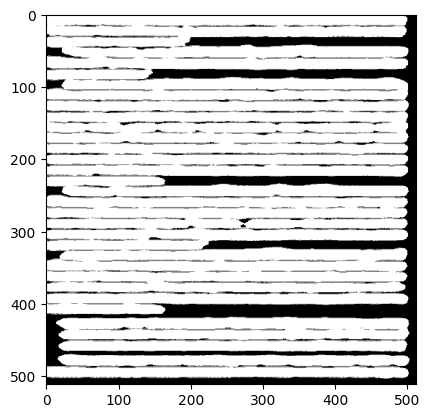

In [12]:
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [13]:
plt.imsave('/content/drive/MyDrive/DataScience/OCR/PageSegData/test_img_mask.JPG',pred)

Now let’s detect the contour around these segmentation mask and draw bounding boxes around the original image using these contour coordinates.

In [14]:
coordinates=[]
img = cv2.imread('/content/drive/MyDrive/DataScience/OCR/PageSegData/test_img_mask.JPG',0)
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/drive/MyDrive/DataScience/OCR/PageSegData/test_img.JPG')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imwrite("output.png",ori_img)

True

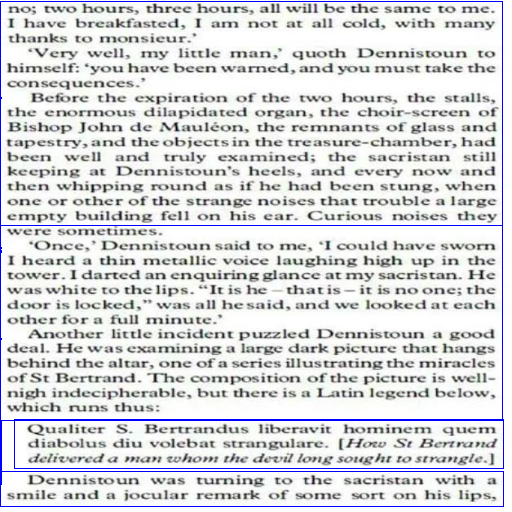

If you use more epochs the output will be better.

### To use the template later

Make sure you have the h5py package installed, as it is needed to save and load models in HDF5 format. You can install it using the pip install h5py command.

In [ ]:
from tensorflow.keras.models import load_model

modelo_carregado = load_model('/content/weights00000001.h5')